# Harvard Data Science Animation Contest
Author: **Michel Kana**

Affiliation: IACS, FAS, Harvard Extension School

In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()
import geopandas as gpd
import requests
import zipfile
import io
import os
os.environ["PROJ_LIB"] = "C:\ProgramData\Anaconda3\Library\share"
import pyproj
from shapely.ops import transform
from functools import partial
import json
from uszipcode import SearchEngine

# Download Redlines Map Data

**Download redline maps from Mapping Inequality website https://dsl.richmond.edu/panorama/redlining**

digitalscholarshiplab.cartodb.com/api/v1/sql?q=with condensed_data as (with ad_data as (SELECT holc_ads.state, holc_ads.city, holc_ads.looplat, holc_ads.looplng, holc_polygons.the_geom, holc_polygons.name, holc_id, holc_grade, cat_id, sub_cat_id, _order, data FROM holc_ad_data right join holc_polygons on holc_ad_data.polygon_id = holc_polygons.neighborhood_id join holc_ads on city_id = holc_polygons.ad_id order by holc_id, cat_id, sub_cat_id, _order) SELECT state, city, looplat, looplng, the_geom, name, holc_id, holc_grade, concat(cat_id, sub_cat_id) as the_id, array_to_string(array_agg(data), ' ') as the_data FROM ad_data group by state, city, looplat, looplng, the_geom, name, holc_id, holc_grade, cat_id, sub_cat_id order by holc_id, the_id) select state, city, looplat, looplng, the_geom, name, holc_id, holc_grade, json_object_agg(the_id, the_data) AS area_description_data from condensed_data group by state, city, looplat, looplng, the_geom, name, holc_id, holc_grade order by holc_id&format=SHP&filename=HOLC_ALL

In [3]:
url = "http://digitalscholarshiplab.cartodb.com/api/v1/sql?q=with%20condensed_data%20as%20(with%20ad_data%20as%20(SELECT%20holc_ads.state%2C%20holc_ads.city%2C%20holc_ads.looplat%2C%20holc_ads.looplng%2C%20holc_polygons.the_geom%2C%20holc_polygons.name%2C%20holc_id%2C%20holc_grade%2C%20cat_id%2C%20sub_cat_id%2C%20_order%2C%20data%20FROM%20holc_ad_data%20right%20join%20holc_polygons%20on%20holc_ad_data.polygon_id%20=%20holc_polygons.neighborhood_id%20join%20holc_ads%20on%20city_id%20=%20holc_polygons.ad_id%20order%20by%20holc_id%2C%20cat_id%2C%20sub_cat_id%2C%20_order)%20SELECT%20state%2C%20city%2C%20looplat%2C%20looplng%2C%20the_geom%2C%20name%2C%20holc_id%2C%20holc_grade%2C%20concat(cat_id%2C%20sub_cat_id)%20as%20the_id%2C%20array_to_string(array_agg(data)%2C%20'%20')%20as%20the_data%20FROM%20ad_data%20group%20by%20state%2C%20city%2C%20looplat%2C%20looplng%2C%20the_geom%2C%20name%2C%20holc_id%2C%20holc_grade%2C%20cat_id%2C%20sub_cat_id%20order%20by%20holc_id%2C%20the_id)%20select%20state%2C%20city%2C%20looplat%2C%20looplng%2C%20the_geom%2C%20name%2C%20holc_id%2C%20holc_grade%2C%20json_object_agg(the_id%2C%20the_data)%20AS%20area_description_data%20from%20condensed_data%20group%20by%20state%2C%20city%2C%20looplat%2C%20looplng%2C%20the_geom%2C%20name%2C%20holc_id%2C%20holc_grade%20order%20by%20holc_id&format=SHP&filename=HOLC_ALL"

try:
    r = requests.get(url, stream=True)
    print(r.status_code)
    if r.status_code == requests.codes.ok:
        zip_ref = zipfile.ZipFile(io.BytesIO(r.content))
        zip_ref.extractall('data/')
        zip_ref.close()
except requests.exceptions.RequestException as e:  
    print(e)

200


**create a shapes dataframe**

In [37]:
df_redlines_map = gpd.read_file('data/HOLC_ALL.shp')

Calculate area in square kilometers

In [38]:
proj = partial(pyproj.transform, pyproj.Proj(init='epsg:4326'),
               pyproj.Proj(init='epsg:3857'))
df_redlines_map['area'] = [transform(proj, g).area/1e+6 for g in df_redlines_map['geometry'].values]
df_redlines_map['centroid_lat'] = df_redlines_map.geometry.centroid.y
df_redlines_map['centroid_long'] = df_redlines_map.geometry.centroid.x
df_redlines_map.head()

,state,city,looplat,looplng,name,holc_id,holc_grade,area_descr,geometry,area,centroid_lat,centroid_long
0,MN,Minneapolis,44.9833,-93.268,None,89R,D,"{ """" : """" }",POLYGON ((-97.48612839914043 35.42771534067164...,1.032775,35.424368,-97.481438
1,CA,Oakland,37.7970,-122.275,None,A,A,"{ """" : """" }",POLYGON ((-122.2025219245971 37.81098621368113...,11.190640,37.823028,-122.195925
2,TN,Nashville,36.1620,-86.780,None,A,A,"{ """" : """" }",POLYGON ((-86.80166790597521 36.11326261230185...,52.158432,36.103906,-86.821152
3,AL,Birmingham,33.5200,-86.799,Mountain Brook Estates and Country Club Garden...,A1,A,"{ ""1b"" : ""Highly restricted. Near two high gra...",POLYGON ((-86.75677744102258 33.49754314104854...,6.848585,33.486846,-86.753315
4,AL,Mobile,30.6920,-88.044,Woodlawn,A1,A,"{ ""10a"" : ""good"", ""5a"" : ""Executives, business...",POLYGON ((-88.09099046015881 30.69194920544831...,0.022540,30.691646,-88.091800


Clean dataframe

In [81]:
df_redlines_map = df_redlines_map[df_redlines_map.holc_grade!='E']

**Add zipcodes**

credits: https://pypi.org/project/uszipcode/

In [76]:
search = SearchEngine(simple_zipcode=True)

In [44]:
i = 0
while i < df_redlines_map.shape[0]:
    df_redlines_map.loc[i:i+100,'zipcode'] = df_redlines_map[i:i+100].apply(lambda row: search.by_coordinates(row.centroid_lat,row.centroid_long, radius=30, returns=1)[0].zipcode, axis=1)
    #df_redlines_map.to_csv('data/df_redlines_map.csv')
    i = i + 100

In [52]:
df_redlines_map.head()

,state,city,looplat,looplng,name,holc_id,holc_grade,area_descr,geometry,area,centroid_lat,centroid_long,zipcode,zip_code
0,MN,Minneapolis,44.983300,-93.268000,None,89R,D,"{ """" : """" }",POLYGON ((-97.48612839914043 35.42771534067164...,1.032775,35.424368,-97.481438,73129,731xx
1,CA,Oakland,37.797000,-122.275000,None,A,A,"{ """" : """" }",POLYGON ((-122.2025219245971 37.81098621368113...,11.190640,37.823028,-122.195925,94611,946xx
2,TN,Nashville,36.162000,-86.780000,None,A,A,"{ """" : """" }",POLYGON ((-86.80166790597521 36.11326261230185...,52.158432,36.103906,-86.821152,37215,372xx
3,AL,Birmingham,33.520000,-86.799000,Mountain Brook Estates and Country Club Garden...,A1,A,"{ ""1b"" : ""Highly restricted. Near two high gra...",POLYGON ((-86.75677744102258 33.49754314104854...,6.848585,33.486846,-86.753315,35223,352xx
4,AL,Mobile,30.692000,-88.044000,Woodlawn,A1,A,"{ ""10a"" : ""good"", ""5a"" : ""Executives, business...",POLYGON ((-88.09099046015881 30.69194920544831...,0.022540,30.691646,-88.091800,36607,366xx
5,AL,Montgomery,32.386000,-86.311000,None,A1,A,"{ ""5a"" : ""Executives, businessm men, retired c...",POLYGON ((-86.28545336088072 32.35886612445277...,3.538868,32.351525,-86.293290,36111,361xx
6,CA,Fresno,36.735505,-119.790517,None,A1,A,"{ ""1"" : ""This is the best residential district...",POLYGON ((-119.8087060465236 36.77828861384437...,0.603263,36.775266,-119.806073,93728,937xx
7,CA,Los Angeles,34.042000,-118.249000,None,A1,A,"{ ""1b"" : ""Business and professional men, white...",POLYGON ((-118.4574409245932 34.15201303915654...,5.030884,34.145845,-118.443301,91423,914xx
8,CA,Oakland,37.797000,-122.275000,None,A1,A,"{ ""5a"" : ""Profession and business men, executi...","POLYGON ((-122.263194014919 37.9003948457167, ...",3.083408,37.897545,-122.269069,94707,947xx
9,CA,Sacramento,38.577000,-121.494000,None,A1,A,"{ ""2g"" : ""Slowly "", ""1b"" : ""Convenience to tr...",POLYGON ((-121.4446111131231 38.56729855685624...,0.396375,38.567231,-121.447055,95819,958xx


**Calculate area ratio per HOLC grade** 

get total area per zipcode

In [40]:
df_redlines = df_redlines_map.groupby(['zipcode']).agg({'area': np.sum}).reset_index().rename(columns={'area': 'zip_area'})
df_redlines.head()

,zipcode,zip_area
0,1013,23.739931
1,1020,34.392252
2,1022,0.373703
3,1040,14.085949
4,1104,0.679078


get total area per state

In [226]:
df_redlines_state = df_redlines_map.groupby(['state']).agg({'area': np.sum}).reset_index().rename(columns={'area': 'state_area'})
df_redlines_state.head()

,state,state_area
0,AL,305.463693
1,CA,1867.831566
2,CO,148.247863
3,CT,330.766901
4,FL,327.591501


calculate the area per HOLC grade per state

In [227]:
df_redlines_state_details = df_redlines_map.groupby(['state','holc_grade']).agg({'area': np.sum}).reset_index().rename(columns={'area': 'holc_area'})
df_redlines_state_details = df_redlines_state_details.merge(df_redlines_state, on='state', how='left')
df_redlines_state_details['holc_ratio'] = df_redlines_state_details.holc_area/df_redlines_state_details.state_area
df_redlines_state_details.head()

,state,holc_grade,holc_area,state_area,holc_ratio
0,AL,A,17.121937,305.463693,0.056052
1,AL,B,27.255619,305.463693,0.089227
2,AL,C,74.240955,305.463693,0.243043
3,AL,D,186.845183,305.463693,0.611677
4,CA,A,214.182573,1867.831566,0.114669


calculate the area per HOLC grade per zipcode

In [229]:
df_redlines_details = df_redlines_map.groupby(['zipcode','holc_grade']).agg({'area': np.sum}).reset_index().rename(columns={'area': 'holc_area'})
df_redlines_details = df_redlines_details.merge(df_redlines[['zipcode','zip_area']], on='zipcode', how='left')
df_redlines_details['holc_ratio'] = df_redlines_details.holc_area/df_redlines_details.zip_area
df_redlines_details.head()

,zipcode,holc_grade,holc_area,zip_area,holc_ratio
0,01013,B,3.777890,23.739931,0.159137
1,01013,C,10.740536,23.739931,0.452425
2,01013,D,9.221505,23.739931,0.388439
3,01020,C,34.392252,34.392252,1.000000
4,01022,D,0.373703,0.373703,1.000000


In [41]:
for grade in ['A', 'B', 'C', 'D']:
    df1 = df_redlines_map[df_redlines_map.holc_grade==grade].groupby(['zipcode']).agg({'area': np.sum}).reset_index().rename(columns={'area': grade + '_area'})
    df_redlines = df_redlines.merge(df1, on='zipcode', how='left')
    df_redlines[grade + '_ratio'] = df_redlines[grade + '_area'] / df_redlines.zip_area
    


calculate the HOLC Reject Ratio as the some of ratios of C and D subzones, plus 90% of the ratio for B zones.

In [42]:
df_redlines.fillna(0, inplace=True)
df_redlines['holc_reject_ratio'] = (.9*df_redlines.B_ratio + df_redlines.C_ratio + df_redlines.D_ratio)

**Add a new column with zip codes in the format 123XX**

In [43]:
df_redlines['zip_code'] = df_redlines['zipcode'].astype('str')
df_redlines['zip_code'] = df_redlines['zip_code'].str.pad(5, 'left', '0')
df_redlines['zip_code'] = df_redlines['zip_code'].str.slice(0,3)
df_redlines['zip_code'] = df_redlines['zip_code'].str.pad(5, 'right', 'x')

In [44]:
df_redlines.head()

,zipcode,zip_area,A_area,A_ratio,B_area,B_ratio,C_area,C_ratio,D_area,D_ratio,holc_reject_ratio,zip_code
0,1013,23.739931,0.000000,0.000000,3.777890,0.159137,10.740536,0.452425,9.221505,0.388439,0.984086,010xx
1,1020,34.392252,0.000000,0.000000,0.000000,0.000000,34.392252,1.000000,0.000000,0.000000,1.000000,010xx
2,1022,0.373703,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.373703,1.000000,1.000000,010xx
3,1040,14.085949,2.660304,0.188862,7.392564,0.524818,3.381083,0.240032,0.651998,0.046287,0.758656,010xx
4,1104,0.679078,0.000000,0.000000,0.679078,1.000000,0.000000,0.000000,0.000000,0.000000,0.900000,011xx


# Redlines EDA

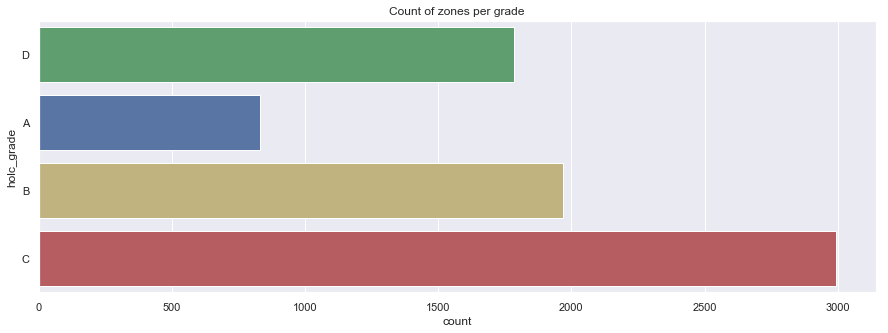

In [233]:
redlines_labels = {'grade': ['A', 'B', 'C', 'D'],
                   'desc':['A - Best', 'B - Still Desirable', 'C - Definitely Declining', 'D - Hazardous'],
                   'color': ['g', 'b','y','r']
         }
fig, ax  = plt.subplots(1,1,figsize=(15,5))
sns.countplot(y='holc_grade',data=df_redlines_map, palette=redlines_labels['color'], ax=ax)
ax.set_title('Count of zones per grade');

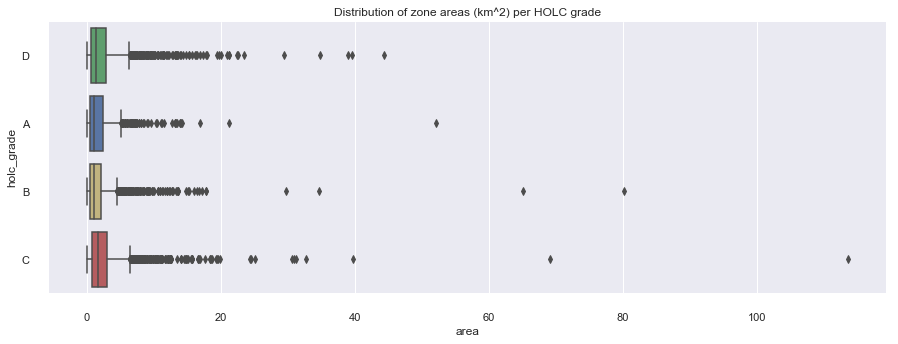

In [234]:
fig, ax  = plt.subplots(1,1,figsize=(15,5))
sns.boxplot(y="holc_grade", x="area", palette=redlines_labels['color'],data=df_redlines_map, ax=ax)
sns.despine(offset=10, trim=True)
ax.set_title('Distribution of zone areas (km^2) per HOLC grade');

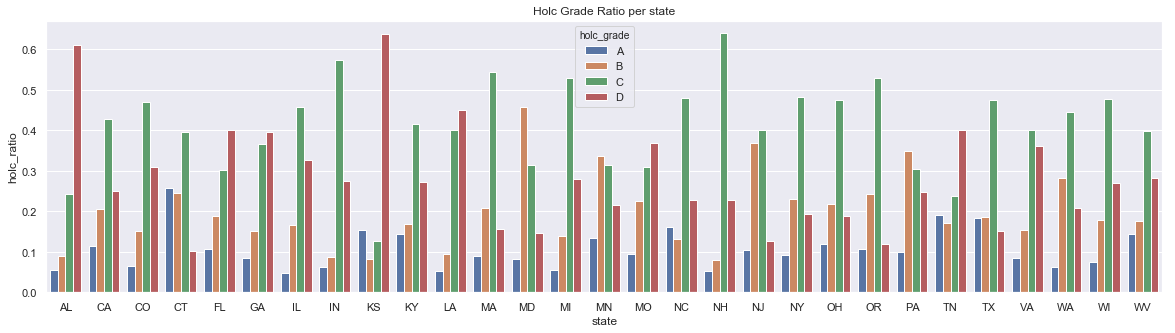

In [235]:
fig, ax  = plt.subplots(1,1,figsize=(20,5))
sns.barplot(x="state", y="holc_ratio", hue='holc_grade', data=df_redlines_state_details, ax=ax)
ax.set_title('Holc Grade Ratio per state');

# Loan Data

**Load LendingClub loans from 2007 till 2018**

In [132]:
df_loan = pd.read_csv('data/df_reject_ratio_2007-2018.csv')

In [130]:
df_loan.head()

,Unnamed: 0,grade,issue_d,rejected,zip_code
0,0,NaN,2007-05-26,1,481xx
1,1,NaN,2007-05-26,1,010xx
2,2,NaN,2007-05-27,1,212xx
3,3,NaN,2007-05-27,1,017xx
4,4,NaN,2007-05-27,1,209xx


In [166]:
print('There have been {} loans requests received at LendingClub since 2015, of which {} have been rejected'.format(df_loan.shape[0], df_loan[df_loan.rejected==1].shape[0])) 

There have been 24473165 loans requests received at LendingClub since 2015, of which 22469074 have been rejected


**Format loan request date**

In [281]:
df1 = df_loan[(df_loan.issue_d.str.len()==10)]


In [286]:
df1['issue_q'] = pd.to_datetime(df1.issue_d, format='%Y-%m-%d').dt.to_period('Q')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [287]:
df1.head()

,Unnamed: 0,grade,issue_d,rejected,zip_code,issue_q
0,0,NaN,2007-05-26,1,481xx,2007Q2
1,1,NaN,2007-05-26,1,010xx,2007Q2
2,2,NaN,2007-05-27,1,212xx,2007Q2
3,3,NaN,2007-05-27,1,017xx,2007Q2
4,4,NaN,2007-05-27,1,209xx,2007Q2


In [288]:
df2 = df_loan[(df_loan.issue_d.str.len()!=10)]

In [290]:
df2['issue_q'] = pd.to_datetime(df2.issue_d, format='%b-%Y').dt.to_period('q')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [291]:
df2.head()

,Unnamed: 0,grade,issue_d,rejected,zip_code,issue_q
22469074,0,B,Dec-2011,0,860xx,2011Q4
22469075,1,C,Dec-2011,0,309xx,2011Q4
22469076,2,C,Dec-2011,0,606xx,2011Q4
22469077,3,C,Dec-2011,0,917xx,2011Q4
22469078,4,B,Dec-2011,0,972xx,2011Q4


In [292]:
df_loan = df1.append(df2)

In [293]:
df_loan.head()

,Unnamed: 0,grade,issue_d,rejected,zip_code,issue_q
0,0,NaN,2007-05-26,1,481xx,2007Q2
1,1,NaN,2007-05-26,1,010xx,2007Q2
2,2,NaN,2007-05-27,1,212xx,2007Q2
3,3,NaN,2007-05-27,1,017xx,2007Q2
4,4,NaN,2007-05-27,1,209xx,2007Q2


**Calculate the loan reject ratio per zipcode**

In [46]:
df_loan_reject_ratio = df_loan[['issue_q','zip_code','rejected']].groupby(['issue_q','zip_code']).agg(['count', 'sum'])
df_loan_reject_ratio.columns = df_loan_reject_ratio.columns.droplevel(level=0)
df_loan_reject_ratio = df_loan_reject_ratio.rename(columns={'count':'lc_total_requested', 'sum':'lc_total_rejected'})
df_loan_reject_ratio['lc_total_accepted'] = df_loan_reject_ratio.lc_total_requested - df_loan_reject_ratio.lc_total_rejected
df_loan_reject_ratio['lc_reject_ratio'] = df_loan_reject_ratio.lc_total_rejected/df_loan_reject_ratio.lc_total_requested
df_loan_reject_ratio = df_loan_reject_ratio.reset_index()

In [172]:
df_loan_reject_ratio.head()

,issue_q,zip_code,lc_total_requested,lc_total_rejected,lc_total_accepted,lc_reject_ratio
0,2007Q2,010xx,2,2,0,1.0
1,2007Q2,011xx,1,1,0,1.0
2,2007Q2,014xx,2,2,0,1.0
3,2007Q2,017xx,1,1,0,1.0
4,2007Q2,018xx,1,1,0,1.0


**Calculate the grade distribution assigned by LendingClub per zipcode**

In [47]:
df_loan_grades = df_loan[df_loan.rejected==0][['issue_q','zip_code','issue_d']].groupby(['issue_q','zip_code']).count().reset_index().rename(columns={'issue_d':'total_accepted'})

In [174]:
df_loan_grades.head()

,issue_q,zip_code,total_accepted
0,2007Q2,021xx,2
1,2007Q2,024xx,1
2,2007Q2,027xx,1
3,2007Q2,061xx,1
4,2007Q2,064xx,1


In [48]:
for grade in ['A', 'B', 'C', 'D', 'E', 'F', 'G']:
    df1 = df_loan[(df_loan.rejected==0)&(df_loan.grade==grade)][['issue_q','zip_code','issue_d']].groupby(['issue_q','zip_code']).count().reset_index().rename(columns={'issue_d': 'LC_' + grade + '_accepted'})
    df_loan_grades = df_loan_grades.merge(df1, on=['issue_q','zip_code'], how='left')
    df_loan_grades['LC_' + grade + '_ratio'] = df_loan_grades['LC_' + grade + '_accepted'] / df_loan_grades.total_accepted

In [176]:
df_loan_grades.head()

,issue_q,zip_code,total_accepted,LC_A_accepted,LC_A_ratio,LC_B_accepted,LC_B_ratio,LC_C_accepted,LC_C_ratio,LC_D_accepted,LC_D_ratio,LC_E_accepted,LC_E_ratio,LC_F_accepted,LC_F_ratio,LC_G_accepted,LC_G_ratio
0,2007Q2,021xx,2,NaN,NaN,1.0,0.5,NaN,NaN,1.0,0.5,NaN,NaN,NaN,NaN,NaN,NaN
1,2007Q2,024xx,1,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2007Q2,027xx,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN
3,2007Q2,061xx,1,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2007Q2,064xx,1,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Redlines with Loan Stats

**Aggregate redline data per 123xx zipcode**

In [49]:
df_redlines_aggr = df_redlines.fillna(0).groupby('zip_code').agg({'zip_area': np.sum, 
                                                         'A_area': np.sum, 
                                                         'B_area': np.sum, 
                                                         'C_area': np.sum, 
                                                         'D_area': np.sum, 
                                                         'A_ratio': np.mean,
                                                         'B_ratio': np.mean,
                                                         'C_ratio': np.mean,
                                                         'D_ratio': np.mean,
                                                         'holc_reject_ratio': np.mean}).reset_index()
df_redlines_aggr.head()

,zip_code,zip_area,A_area,B_area,C_area,D_area,A_ratio,B_ratio,C_ratio,D_ratio,holc_reject_ratio
0,010xx,72.591834,2.660304,11.170454,48.513870,10.247206,0.047216,0.170989,0.423114,0.358681,0.935686
1,011xx,0.679078,0.000000,0.679078,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.900000
2,017xx,3.301145,0.000000,0.000000,3.301145,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
3,018xx,49.367976,4.581122,11.449981,29.460002,3.876871,0.067838,0.193291,0.664292,0.074579,0.912833
4,019xx,14.614127,0.000000,1.037790,6.578502,6.997835,0.000000,0.071013,0.450147,0.478840,0.992899


**Merge redlines with loans data**

In [50]:
df_redlines_loan = df_loan_reject_ratio.merge(df_loan_grades, on=['zip_code','issue_q'], how='left').merge(df_redlines_aggr, on='zip_code', how='left')

In [51]:
df_redlines_loan.issue_q = df_redlines_loan.issue_q.astype('str')
df_redlines_loan.fillna(0, inplace=True)

In [169]:
df_redlines_loan.head()

,issue_q,zip_code,lc_total_requested,lc_total_rejected,lc_total_accepted,lc_reject_ratio,total_accepted,LC_A_accepted,LC_A_ratio,LC_B_accepted,...,zip_area,A_area,B_area,C_area,D_area,A_ratio,B_ratio,C_ratio,D_ratio,holc_reject_ratio
0,2007Q2,010xx,2,2,0,1.0,0.0,0.0,0.0,0.0,...,72.591834,2.660304,11.170454,48.513870,10.247206,0.047216,0.170989,0.423114,0.358681,0.935686
1,2007Q2,011xx,1,1,0,1.0,0.0,0.0,0.0,0.0,...,0.679078,0.000000,0.679078,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.900000
2,2007Q2,014xx,2,2,0,1.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,2007Q2,017xx,1,1,0,1.0,0.0,0.0,0.0,0.0,...,3.301145,0.000000,0.000000,3.301145,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
4,2007Q2,018xx,1,1,0,1.0,0.0,0.0,0.0,0.0,...,49.367976,4.581122,11.449981,29.460002,3.876871,0.067838,0.193291,0.664292,0.074579,0.912833


**EDA - Redlines in today's lending**

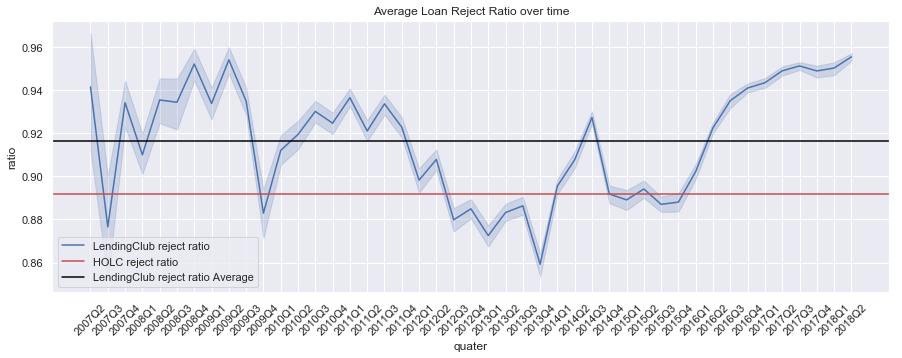

In [574]:
fig, ax = plt.subplots(1,1,figsize=(15,5))
sns.lineplot(x="issue_q", y="lc_reject_ratio",data=df_redlines_loan, ax=ax, label='LendingClub reject ratio')
plt.axhline(df_redlines_loan[df_redlines_loan.holc_reject_ratio>0].holc_reject_ratio.mean(), color='r', label='HOLC reject ratio')
plt.axhline(df_redlines_loan.lc_reject_ratio.mean(), color='black', label='LendingClub reject ratio Average')
plt.xlabel('quater')
plt.ylabel('ratio')
plt.title('Average Loan Reject Ratio over time')
plt.legend()
plt.xticks(rotation=45);

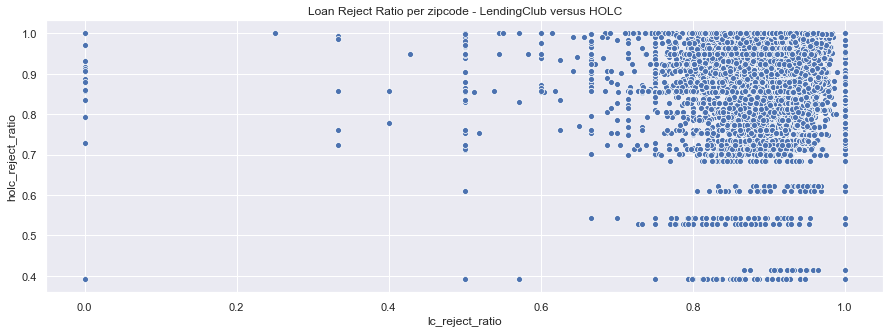

In [576]:
fig, ax = plt.subplots(1,1,figsize=(15,5))
sns.scatterplot(x='lc_reject_ratio', y='holc_reject_ratio', data=df_redlines_loan[df_redlines_loan.holc_reject_ratio>0], ax=ax)
plt.title('Loan Reject Ratio per zipcode - LendingClub versus HOLC');

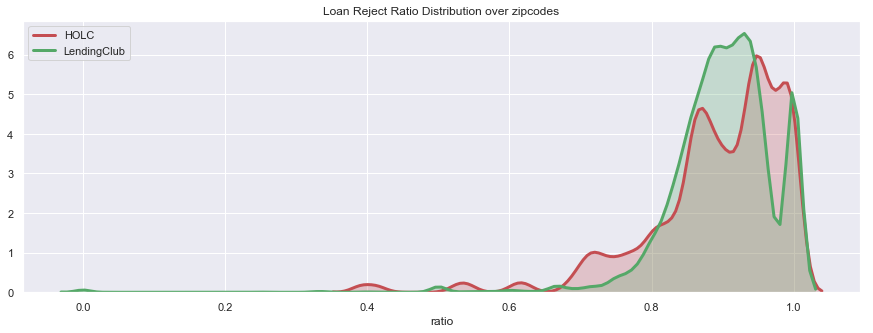

In [593]:
fig, ax = plt.subplots(1,1,figsize=(15,5))
sns.distplot(df_redlines_loan[df_redlines_loan.holc_reject_ratio>0].holc_reject_ratio, color='r', hist = False, kde = True, kde_kws = {'shade': True, 'linewidth': 3}, label='HOLC', ax=ax)
sns.distplot(df_redlines_loan[df_redlines_loan.holc_reject_ratio>0].lc_reject_ratio, color='g', hist = False, kde = True, kde_kws = {'shade': True, 'linewidth': 3}, label='LendingClub', ax=ax)
plt.xlabel('ratio')
plt.title('Loan Reject Ratio Distribution over zipcodes');

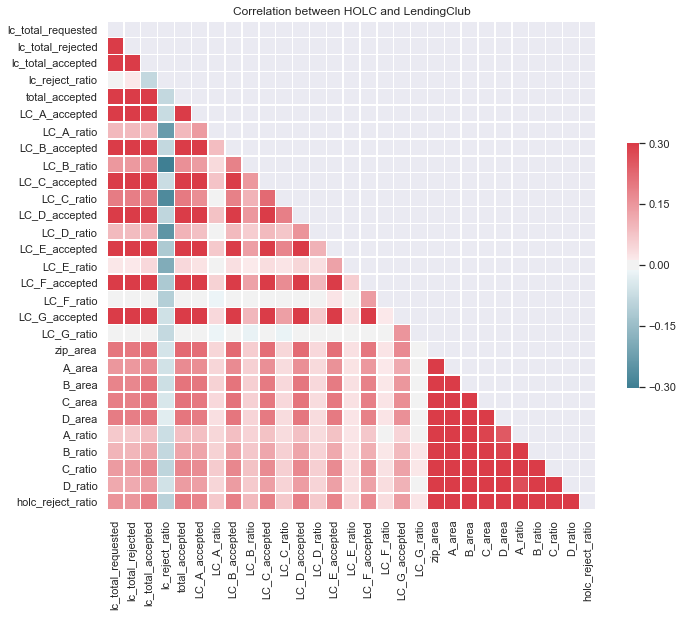

In [582]:
corr = df_redlines_loan.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
ax.set_title('Correlation between HOLC and LendingClub');

In [ ]:
f = df_redlines_loan[(df_redlines_loan.holc_reject_ratio==1)&(df_redlines_loan.lc_reject_ratio!=1)].sort_values(by='lc_reject_ratio', ascending=False).reset_index()[['zip_code', 'holc_reject_ratio', 'lc_reject_ratio', 'LC_A_ratio', 'LC_A_ratio', 'LC_B_ratio', 'LC_C_ratio', 'LC_D_ratio', 'LC_E_ratio', 'LC_F_ratio', 'LC_G_ratio']]

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:679: UserWarning:

Passing a 2D dataset for a bivariate plot is deprecated in favor of kdeplot(x, y), and it will cause an error in future versions. Please update your code.



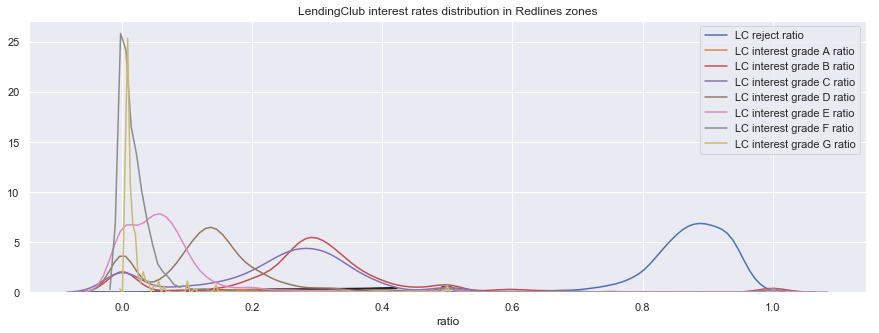

In [594]:
fig, ax = plt.subplots(1,1,figsize=(15,5))
sns.distplot(f.lc_reject_ratio, hist = False, kde = True, label='LC reject ratio', ax=ax)
sns.distplot(f.LC_A_ratio, hist = False, kde = True, label='LC interest grade A ratio', ax=ax)
sns.distplot(f.LC_B_ratio, hist = False, kde = True, label='LC interest grade B ratio', ax=ax)
sns.distplot(f.LC_C_ratio, hist = False, kde = True, label='LC interest grade C ratio', ax=ax)
sns.distplot(f.LC_D_ratio, hist = False, kde = True, label='LC interest grade D ratio', ax=ax)
sns.distplot(f.LC_E_ratio, hist = False, kde = True, label='LC interest grade E ratio', ax=ax)
sns.distplot(f.LC_F_ratio, hist = False, kde = True, label='LC interest grade F ratio', ax=ax)
sns.distplot(f.LC_G_ratio, hist = False, kde = True, label='LC interest grade G ratio', ax=ax)
plt.xlabel('ratio')
ax.set_title('LendingClub interest rates distribution in Redlines zones');

# Mapping LendingClub data on HOLC maps

**Load zip code shapes map**

In [27]:
df_zipcodes = gpd.read_file('data/us_zipcodes/cb_2017_us_zcta510_500k.shp')

In [28]:
df_zipcodes.rename(columns={'ZCTA5CE10':'zipcode'}, inplace=True)
df_zipcodes['zip_code'] = df_zipcodes['zipcode'].astype('str')
df_zipcodes['zip_code'] = df_zipcodes['zip_code'].str.pad(5, 'left', '0')
df_zipcodes['zip_code'] = df_zipcodes['zip_code'].str.slice(0,3)
df_zipcodes['zip_code'] = df_zipcodes['zip_code'].str.pad(5, 'right', 'x')

add state and county

In [29]:
search = SearchEngine(simple_zipcode=True)
df_zipcodes['state'] = df_zipcodes.apply(lambda row: search.by_zipcode(row.zipcode).state, axis=1)
df_zipcodes['county'] = df_zipcodes.apply(lambda row: search.by_zipcode(row.zipcode).county, axis=1)

In [217]:
df_zipcodes.head()

,zipcode,AFFGEOID10,GEOID10,ALAND10,AWATER10,geometry,state,county,zip_code
0,35442,8600000US35442,35442,610213891,10838694,"(POLYGON ((-88.252618 32.92675, -88.249724 32....",AL,Pickens County,354xx
1,85365,8600000US85365,85365,3545016067,9766486,"(POLYGON ((-114.684663 32.687389, -114.676063 ...",AZ,Yuma County,853xx
2,71973,8600000US71973,71973,204670474,1264709,"POLYGON ((-94.46643176650841 34.330735, -94.46...",AR,Polk County,719xx
3,95445,8600000US95445,95445,221559097,7363179,"POLYGON ((-123.643051 38.851233, -123.641401 3...",CA,Mendocino County,954xx
4,06870,8600000US06870,06870,5945321,3841130,"POLYGON ((-73.58765810889219 41.0076522198727,...",CT,Fairfield County,068xx


format redlines zipcodes to 5 digits format

In [54]:
df_redlines.zipcode = df_redlines.zipcode.astype('str')
df_redlines.zipcode = df_redlines.zipcode.str.pad(5, 'left', '0')

**add redline shapes (polygons) to US zipcodes shapes (polygons)**

In [56]:
df_redlines_maps = df_zipcodes.merge(df_redlines, on='zipcode', how='left')

consider only mainland US states

In [57]:
df_redlines_maps = df_redlines_maps[~df_redlines_maps.state.isin(['AK','HI', 'AA', 'AE','AP','PR','RI','VI'])]

fill missing HOLC ratios with 0 for zip codes where there are no HOLC zones

In [59]:
df_redlines_maps.fillna(0, inplace=True)
df_redlines_maps.head()

,zipcode,AFFGEOID10,GEOID10,ALAND10,AWATER10,geometry,zip_code_x,state,county,zip_area,A_area,A_ratio,B_area,B_ratio,C_area,C_ratio,D_area,D_ratio,holc_reject_ratio,zip_code_y
0,35442,8600000US35442,35442,610213891,10838694,"(POLYGON ((-88.252618 32.92675, -88.249724 32....",354xx,AL,Pickens County,0.00000,0.00000,0.000000,0.0,0.0,0.00000,0.000000,0.0,0.0,0.000000,0
1,85365,8600000US85365,85365,3545016067,9766486,"(POLYGON ((-114.684663 32.687389, -114.676063 ...",853xx,AZ,Yuma County,0.00000,0.00000,0.000000,0.0,0.0,0.00000,0.000000,0.0,0.0,0.000000,0
2,71973,8600000US71973,71973,204670474,1264709,"POLYGON ((-94.46643176650841 34.330735, -94.46...",719xx,AR,Polk County,0.00000,0.00000,0.000000,0.0,0.0,0.00000,0.000000,0.0,0.0,0.000000,0
3,95445,8600000US95445,95445,221559097,7363179,"POLYGON ((-123.643051 38.851233, -123.641401 3...",954xx,CA,Mendocino County,0.00000,0.00000,0.000000,0.0,0.0,0.00000,0.000000,0.0,0.0,0.000000,0
4,06870,8600000US06870,06870,5945321,3841130,"POLYGON ((-73.58765810889219 41.0076522198727,...",068xx,CT,Fairfield County,4.14391,1.33697,0.322635,0.0,0.0,2.80694,0.677365,0.0,0.0,0.677365,068xx


**Load US baseline states' map's shapefile**

In [99]:
df_map_us = gpd.read_file('data/states.shp')

In [18]:
df_map_us.head()

,STATE_NAME,DRAWSEQ,STATE_FIPS,SUB_REGION,STATE_ABBR,geometry
0,Hawaii,1,15,Pacific,HI,(POLYGON ((-160.0738033454681 22.0041773479577...
1,Washington,2,53,Pacific,WA,(POLYGON ((-122.4020153103835 48.2252163723779...
2,Montana,3,30,Mountain,MT,POLYGON ((-111.4754253002074 44.70216236909688...
3,Maine,4,23,New England,ME,(POLYGON ((-69.77727626137293 44.0741483685119...
4,North Dakota,5,38,West North Central,ND,POLYGON ((-98.73043728833767 45.93827137024809...


**Prepare the data for plotting**

* map layer 0: US baseline states' map - **light blue color**
* map layer 1: HOLC redlining map - **red circles**
* map layer 2: LendingClub Reject Ratio - **green shapes**
* map layer 3: LendingClub Interest Rate - **magenta shapes**

**green** is an indicator of very high reject ratio by LendingClub (>90%).

**dark violet** is an indicator of strong correlation between HOLC redlining and LendingClub rejects. Violet color is obtained when the red shape (from HOLC) is overlayed by the green shape (from LendingClub)

**dark magenta** is an indicator of strong correlation between HOLC redlining and LendingClub high interest rate.

In [101]:
dfm = df_redlines_maps[df_redlines_maps.zip_area>0]
dfz = df_zipcodes[~df_zipcodes.state.isin(['AK','HI', 'AA', 'AE','AP','PR','RI','VI'])]
dfr = df_loan_reject_ratio[df_loan_reject_ratio.lc_reject_ratio>.9]
dfg = df_loan_grades.fillna(0)
dfg = dfg[dfg.LC_A_ratio+dfg.LC_B_ratio+dfg.LC_C_ratio<.5]
dfu = df_map_us[~df_map_us.STATE_ABBR.isin(['AK','HI', 'AA', 'AE','AP','PR','RI','VI'])]

In [80]:
dfmc = dfm.copy()
dfmc.rename(columns={'geometry': 'borders'}).set_geometry('borders')
dfmc['centroid_column'] = dfmc.centroid
dfmc = dfmc.set_geometry('centroid_column')

## HOLC Redlining Map

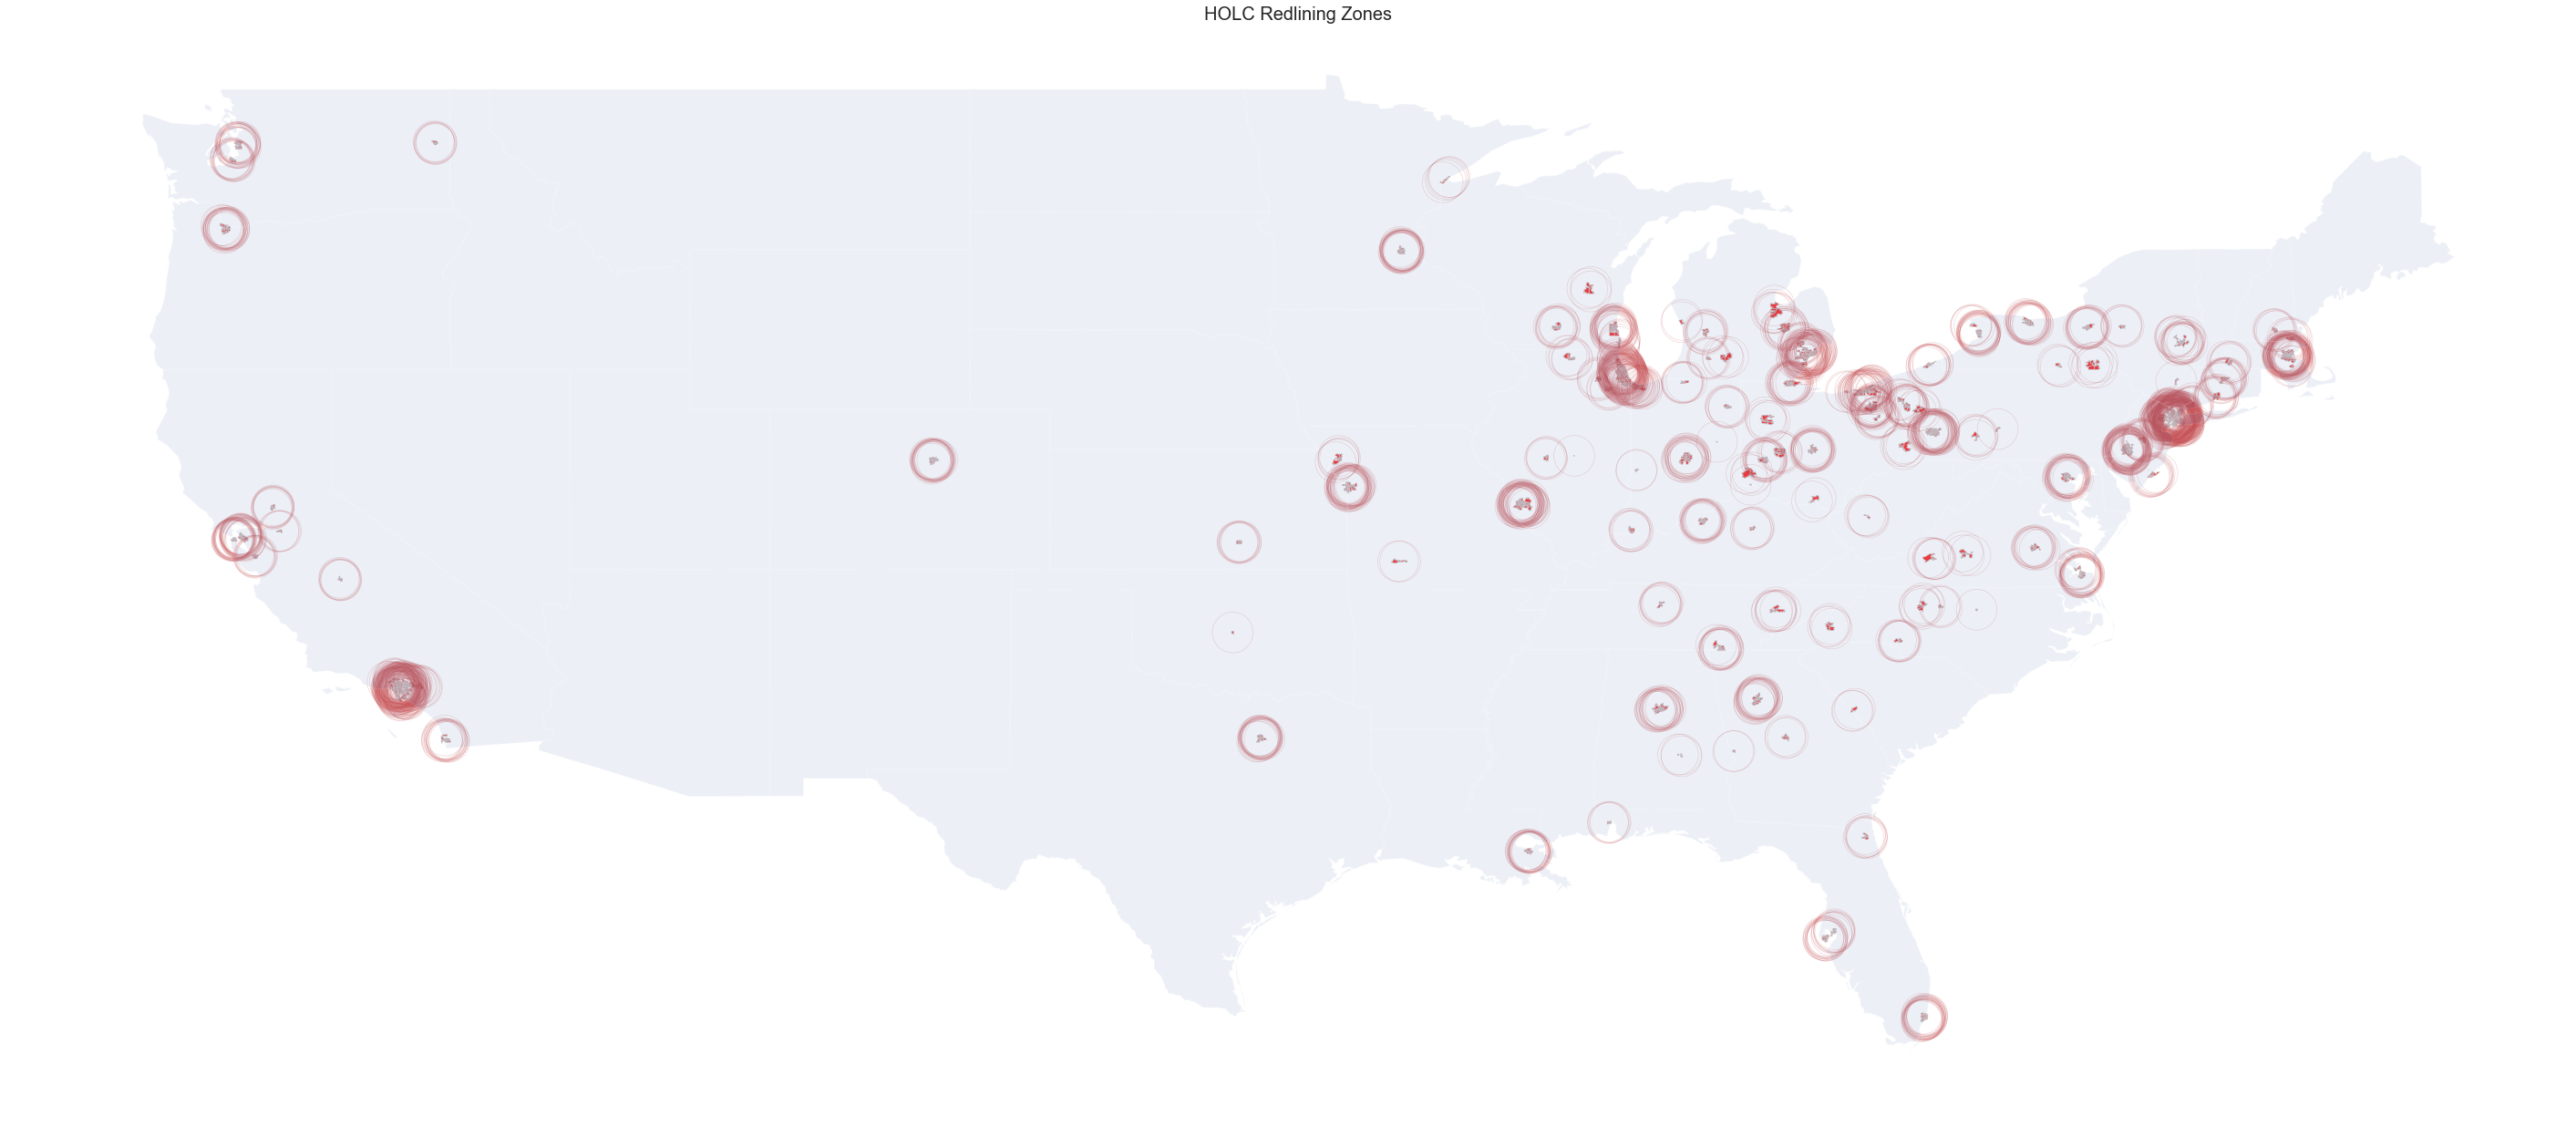

In [117]:
fig, ax = plt.subplots(1, figsize=(50, 50))
dfm.plot(facecolor='red', linewidth=0.8, ax=ax, edgecolor='0.8', alpha=0.8)
dfmc.plot(marker='o', facecolors='none', edgecolors='r', linewidth=0.8, markersize=2000, alpha=.2, ax=ax)
dfu.plot(ax=ax, alpha=.1)
ax.axis('off')
ax.set_title('HOLC Redlining Zones', fontdict={'fontsize': '20', 'fontweight' : '3'});

## LendingClub High Rejects & Interest Rates and HOLC Redlining

for each quarter we generate a map.

C:\ProgramData\Anaconda3\lib\site-packages\geopandas\plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\geopandas\plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\geopandas\plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\geopandas\plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


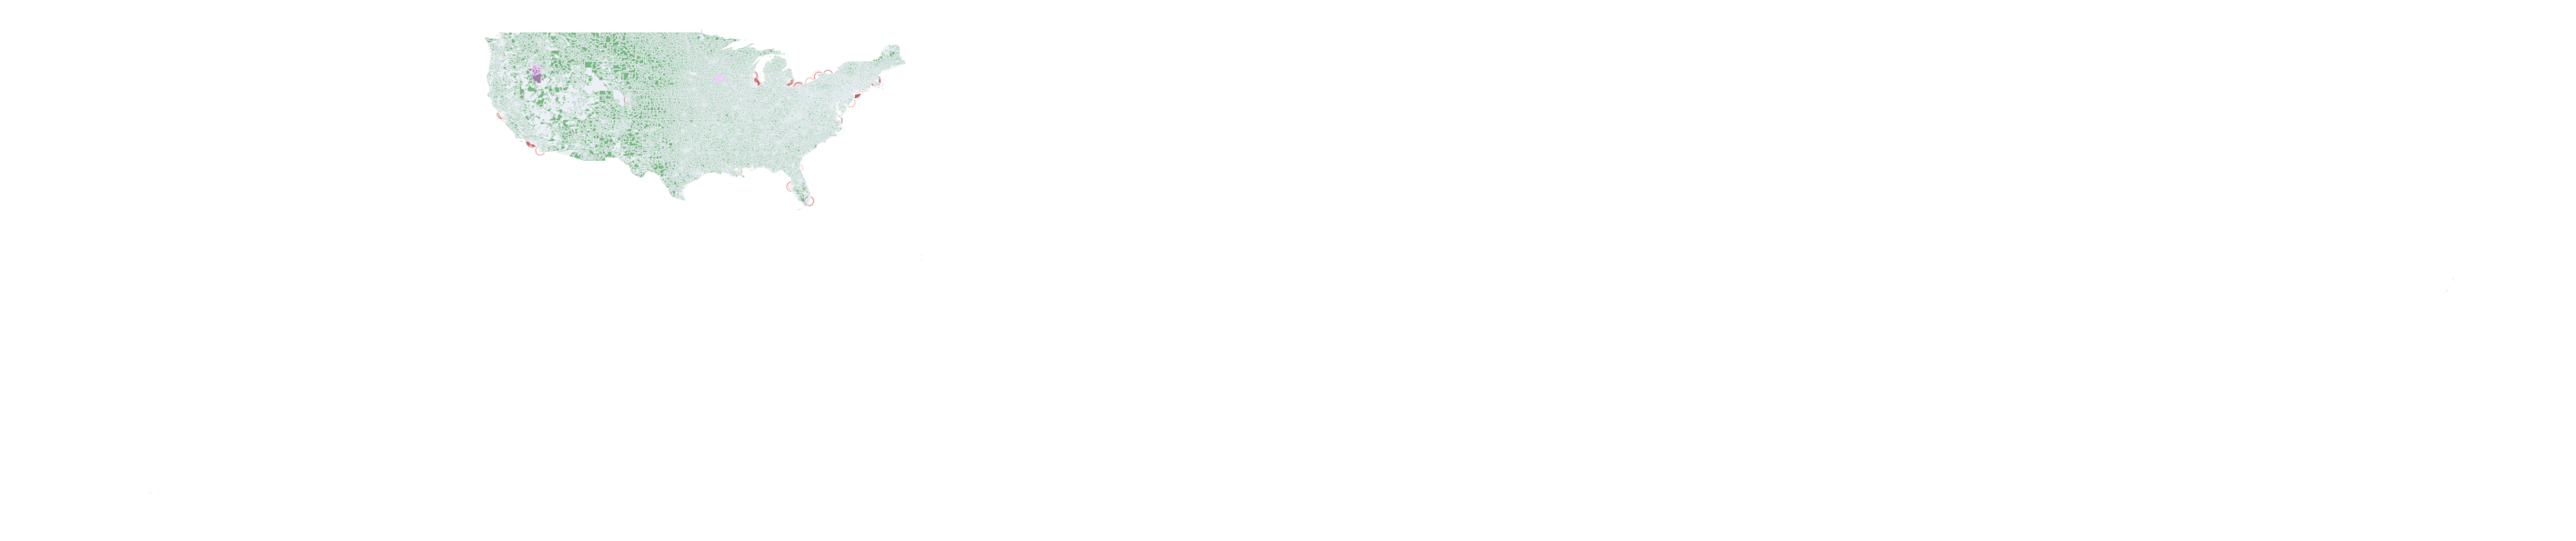

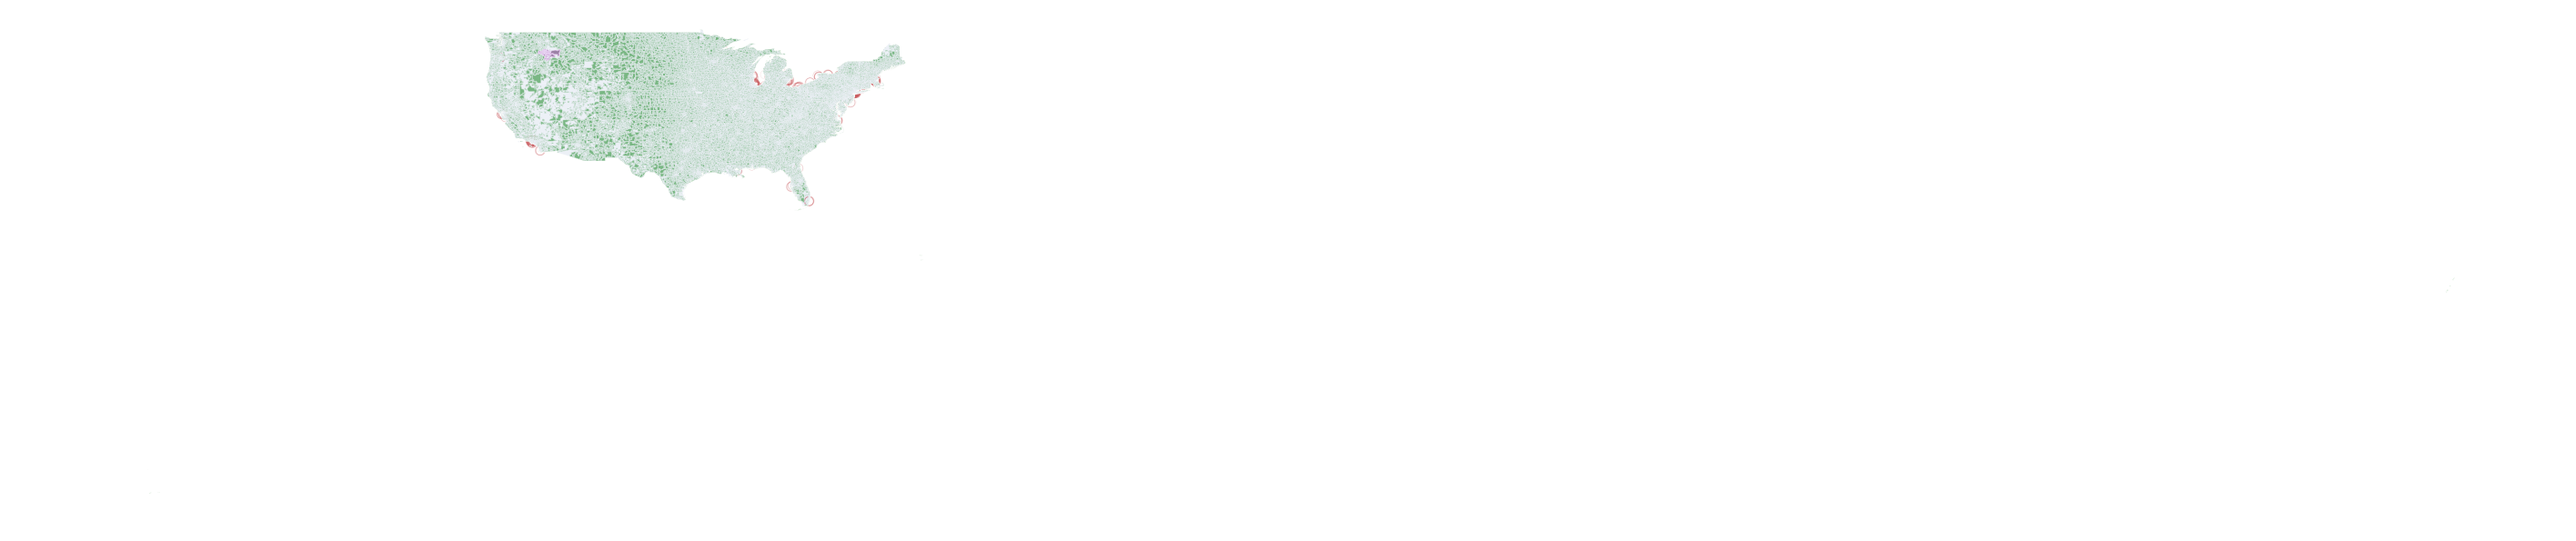

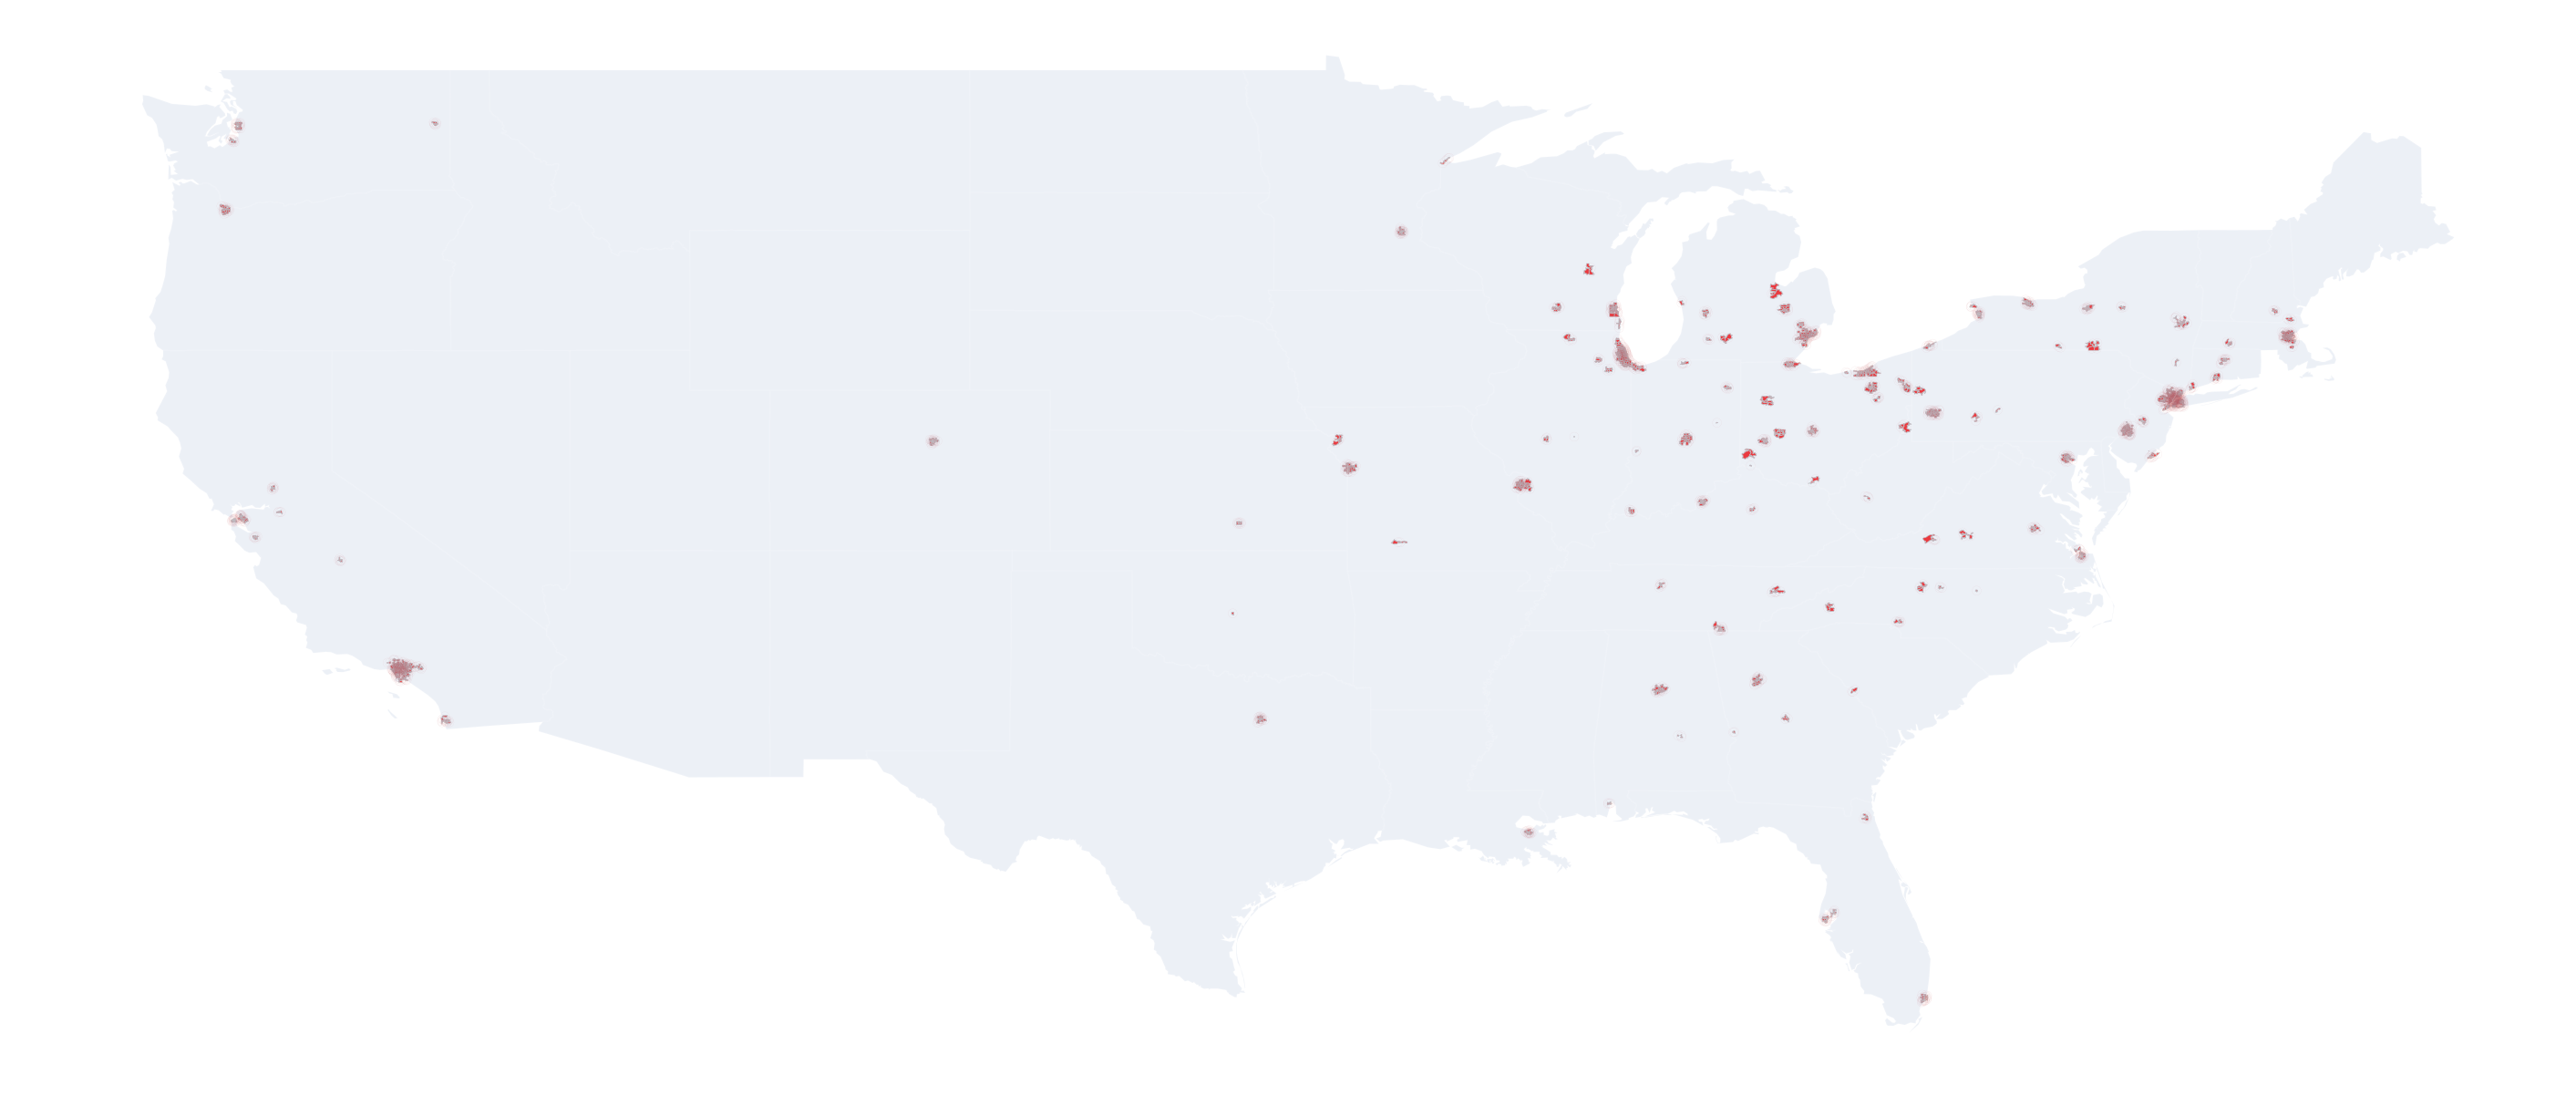

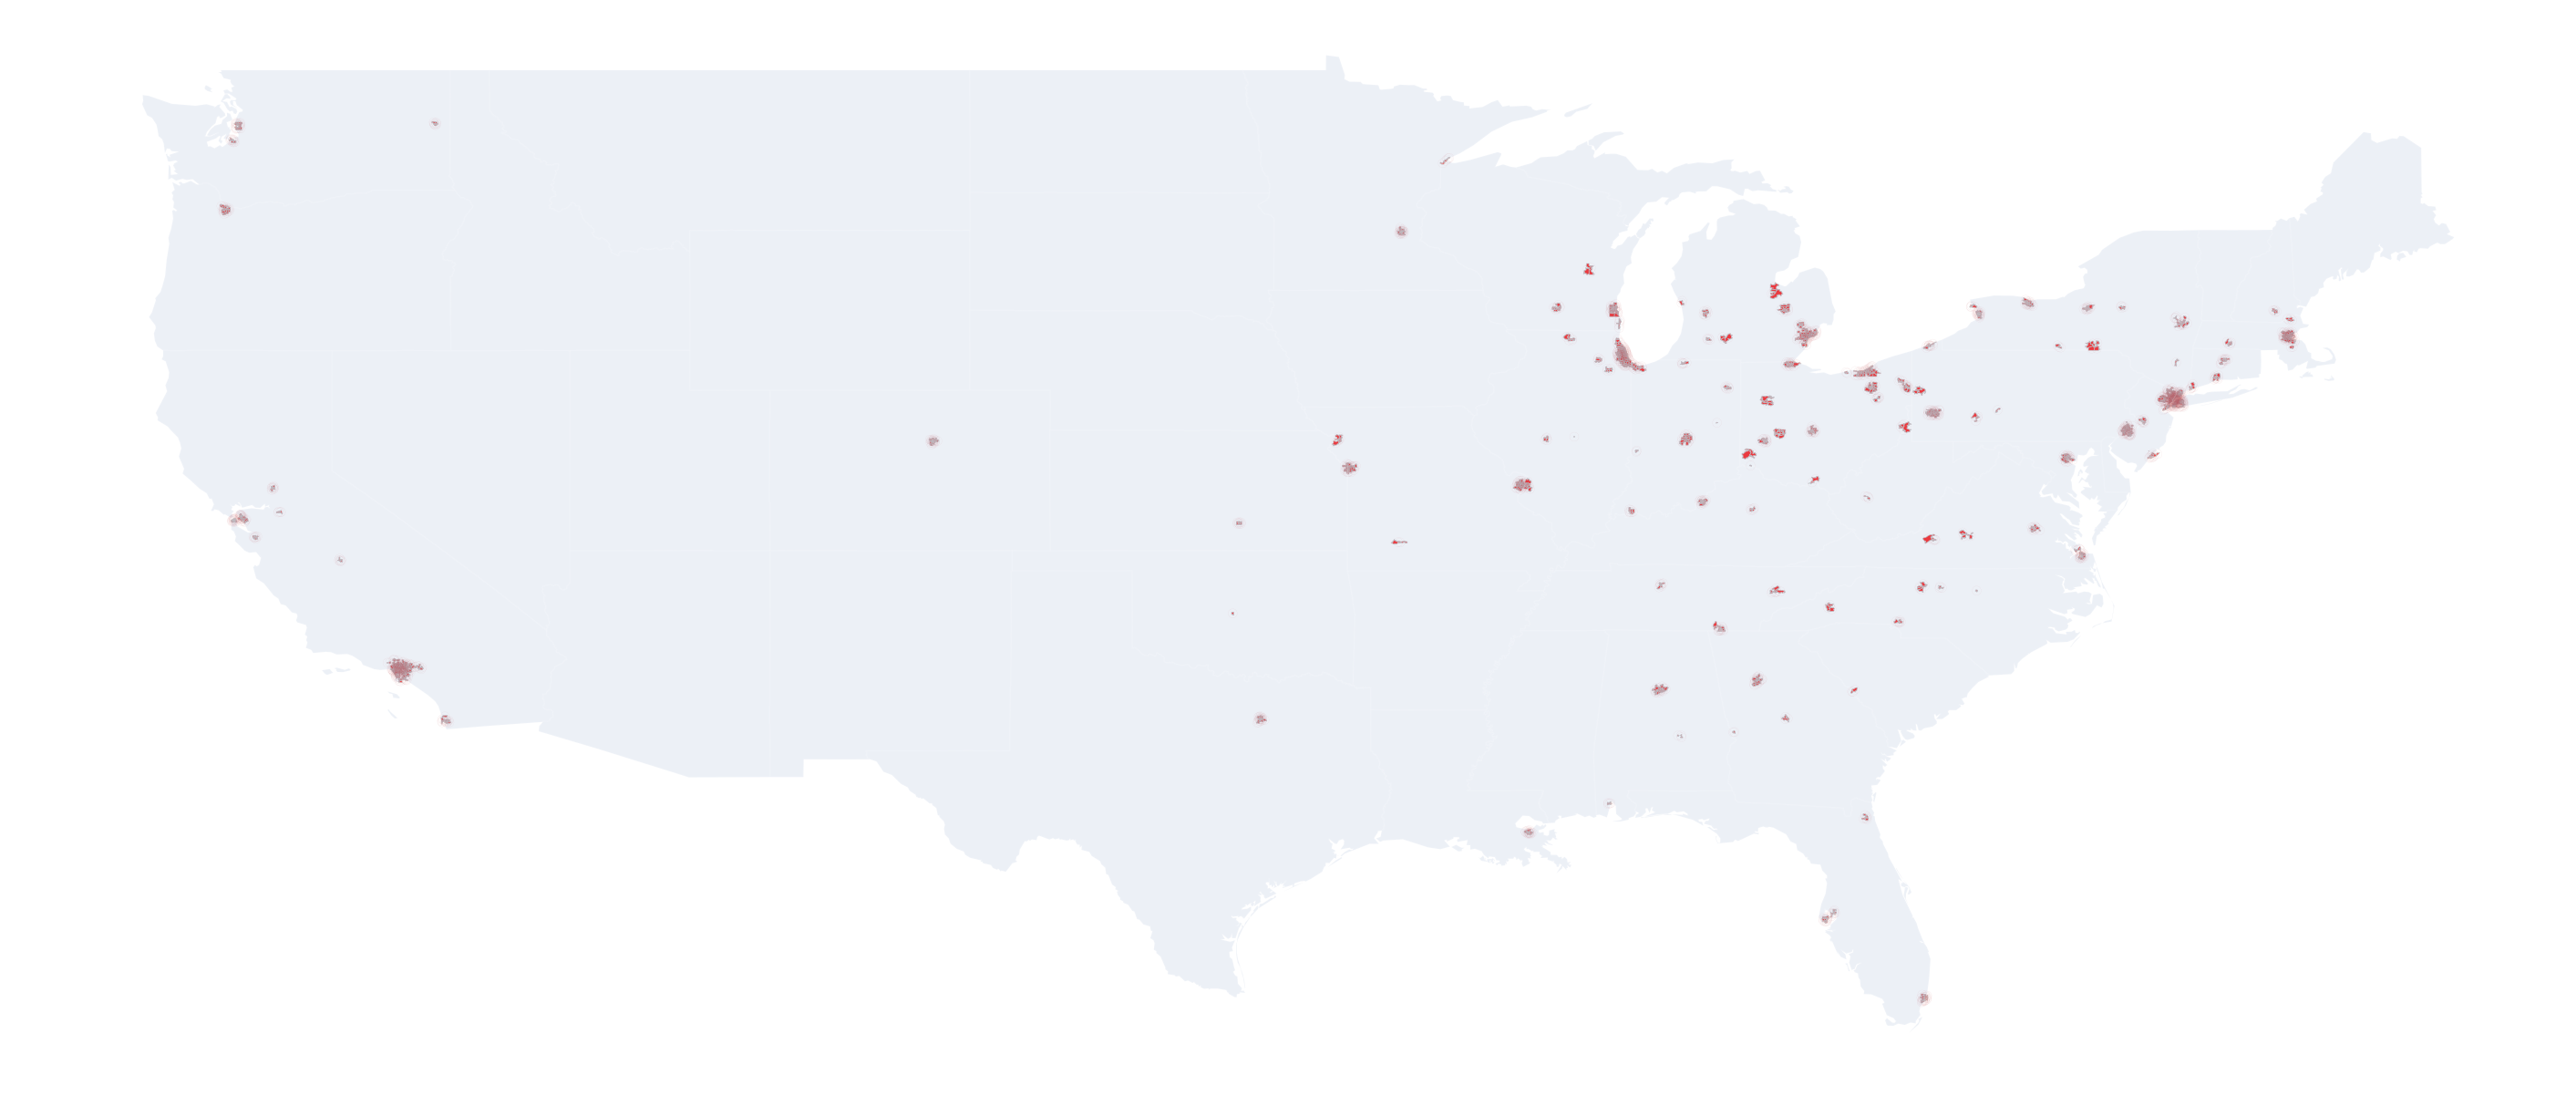

In [111]:
quarters = df_loan_reject_ratio.issue_q.unique()
for q in quarters:
    fig, ax = plt.subplots(1, figsize=(50, 50))
    dfm.plot(facecolor='red', linewidth=0.8, ax=ax, edgecolor='0.8', alpha=0.8)
    dfmc.plot(marker='o', facecolors='none', edgecolors='r', linewidth=0.2, markersize=100, alpha=.2, ax=ax)
    ax.axis('off')
    #ax.set_title('HOLC Redlines zones', fontdict={'fontsize': '20', 'fontweight' : '3'})
    dfz.merge(dfr[dfr.issue_q==q], on='zip_code', how='inner').plot(facecolor='green', ax=ax, alpha=.5)
    dfz.merge(dfg[dfg.issue_q==q], on='zip_code', how='inner').plot(facecolor='magenta', ax=ax, alpha=.3)
    f = dfu.plot(ax=ax, alpha=.1)
    f.get_figure().savefig(q+"_loans_reject_ratio.png", dpi=300)